In [2]:
from sklearn.cluster import DBSCAN


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [4]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [5]:
def get_tensor(df):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    dfc = df.copy()

    df = dfc[energy_cols]

    tensor = df.values.reshape((len(df), 7, stop - start))
    return tensor


def create_region_df_dfc_static(region, year):
    df, dfc = create_matrix_single_region(region, year)
    tensor = get_tensor(df)
    static_region = df[['area', 'total_occupants', 'num_rooms']].copy()
    static_region['area'] = static_region['area'].div(4000)
    static_region['total_occupants'] = static_region['total_occupants'].div(8)
    static_region['num_rooms'] = static_region['num_rooms'].div(8)
    static_region =static_region.values
    return df, dfc, tensor, static_region


In [6]:
au_df, au_dfc, au_tensor, au_static = create_region_df_dfc_static('Austin', year)
sd_df, sd_dfc, sd_tensor, sd_static = create_region_df_dfc_static('SanDiego', year)

In [7]:
sd_agg = sd_df.loc[:, 'aggregate_1':'aggregate_12']
au_agg = au_df.loc[:, 'aggregate_1':'aggregate_12']

In [8]:
sd_agg = np.nan_to_num(sd_agg)
au_agg = np.nan_to_num(au_agg)

In [9]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(sd_agg)

In [38]:
from sklearn.metrics.pairwise import pairwise_distances

In [125]:
M = np.arange(4).reshape((2,2))

In [127]:
pairwise_distances(M,M, 'euclidean')

array([[ 0.        ,  2.82842712],
       [ 2.82842712,  0.        ]])

In [133]:
k = np.dot(M.T, M)
M.T

array([[0, 2],
       [1, 3]])

In [56]:
from scipy.spatial.distance import pdist

In [62]:
pdist(sd_agg, 'euclidean')[38]

1349.1812711799673

In [73]:
def learn_HAT_adagrad_graph_2(case, E_np_masked, sim, a, b, num_iter=2000, lr=0.1, dis=False, lam = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_graph_laplacian_2
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    
    costs = [cost(H, A, T, sim, E_np_masked, lam, case)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, sim, E_np_masked, lam, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        
        costs.append(cost(H, A, T, sim, E_np_masked, lam, case))
        
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, sim, E_np_masked, lam, case))
    return H, A, T, Hs, As, Ts, HATs, costs

In [111]:
def cost_graph_laplacian_2(H, A, T, sim, E_np_masked, lam, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
#     print H
#     dist = pairwise_distances(H, H, 'l2')
#     dist = pdist(H, 'euclidean')
    error_2 = 0
    
    n_sample, n_feature = H.shape
    for i in range(n_sample):
        for j in range(i+1, n_sample):
            error_2 += sim[i][j]*np.linalg.norm(H[i] - H[j])
    
    
    return np.sqrt((error_1**2).mean()) + lam * error_2

In [112]:
sim_sd = cosine_similarity(sd_agg)
a = 3
b = 3

In [138]:
%%time
H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_2(2, sd_tensor, sim_sd, a, b, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)


463.574254268
148.031126371
114.171491371
109.036860718
CPU times: user 5min 15s, sys: 16 ms, total: 5min 15s
Wall time: 5min 15s


In [148]:
%%time
L_au = get_L_NN(au_agg)

H_au_3, A_au_3, T_au_3, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(2, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)


915.939671828
327.007361899
187.359451834
176.244950828
CPU times: user 1min 9s, sys: 376 ms, total: 1min 9s
Wall time: 17.5 s


In [139]:
def get_L_DBSCAN(X):
    db = DBSCAN(eps=500, min_samples=1, metric=distance).fit(X)
    labels = db.labels_
    n_sample, n_feature = X.shape
    W = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        label = labels[i]
        neighbours = [j for j,x in enumerate(labels) if x == label]
        for k in neighbours:
            W[i][k] = 1
    K = np.dot(W, np.ones((n_sample, n_sample)))        
    D = np.diag(np.diag(K))
    return D-W

In [140]:
from sklearn.neighbors import NearestNeighbors
def get_L_NN(X):
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    n_sample, n_feature = X.shape
    W = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        for j in indices[i]:
            W[i][j] = 1
            W[j][i] = 1
    K = np.dot(W, np.ones((n_sample, n_sample)))
    D = np.diag(np.diag(K))
    return D - W

In [141]:
def cost_graph_laplacian(H, A, T, L, E_np_masked, lam, case):
    HAT = multiply_case(H, A, T, case)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    HTL = np.dot(H.T, L)
    HTLH = np.dot(HTL, H)
    error_2 = np.trace(HTLH)
    
    return np.sqrt((error_1**2).mean()) + lam * error_2

In [145]:
def learn_HAT_adagrad_graph(case, E_np_masked, L, a, b, num_iter=2000, lr=0.1, dis=False, lam = 1, H_known=None,
                      A_known=None, T_known=None, random_seed=0, eps=1e-8, penalty_coeff=0.0):

    cost = cost_graph_laplacian
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_T = np.zeros_like(T)

    Hs = [H.copy()]
    As = [A.copy()]
    Ts = [T.copy()]
    
    costs = [cost(H, A, T, L, E_np_masked, lam, case)]
    HATs = [multiply_case(H, A, T, case)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, L, E_np_masked, lam, case)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)
        sum_square_gradients_T += eps + np.square(del_t)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        A -= lr_a * del_a
        T -= lr_t * del_t
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
        
        costs.append(cost(H, A, T, L, E_np_masked, lam, case))
        
        HATs.append(multiply_case(H, A, T, case))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, L, E_np_masked, lam, case))
    return H, A, T, Hs, As, Ts, HATs, costs

In [219]:
a = 5
b = 3
c = 3
L_au = get_L_NN(au_agg)
H_au_2, A_au_2, T_au_2, F_au, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph_2(case, au_tensor, L_au, au_agg, a, b, c, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)

H_au_3, A_au_3, T_au_3, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph_3(case, au_tensor, L_au, a, b, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)



1733.34341802
1002.7556091
956.086922846
942.479788446
1166.87000311
271.119788994
180.348376079
170.271761619


In [220]:
HAT_2 = multiply_case(H_au_2, A_au_2, T_au_2, case)
HAT_3 = multiply_case(H_au_3, A_au_3, T_au_3, case)

In [221]:
pred_2 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_2[appliance_name] = []
    pred_2[appliance_name].append(pd.DataFrame(HAT_2[:,appliance_id,:], index=au_df.index))

In [222]:
pred_3 = {}

for appliance_name, appliance_id in appliance_index.iteritems():
    pred_3[appliance_name] = []
    pred_3[appliance_name].append(pd.DataFrame(HAT_3[:,appliance_id,:], index=au_df.index))

In [223]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction
out_2 = {}
out_3 = {}

for appliance in APPLIANCES_ORDER[1:]:
    out_2[appliance] = {}
    out_3[appliance] = {}
    s_2 = pd.concat(pred_2[appliance]).ix[au_df.index]
    s_3 = pd.concat(pred_3[appliance]).ix[au_df.index]
    if appliance=="hvac":
        out_2[appliance] = compute_rmse_fraction(appliance,s_2[range(4, 10)],'Austin')[2]
        out_3[appliance] = compute_rmse_fraction(appliance,s_3[range(4, 10)],'Austin')[2]
    else:   
        out_2[appliance] = compute_rmse_fraction(appliance, s_2,'Austin')[2]
        out_3[appliance] = compute_rmse_fraction(appliance, s_3,'Austin')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [224]:
out_2

{'dw': 1.2757097247589098,
 'fridge': 3.5959613227322991,
 'hvac': 10.504184158536992,
 'mw': 1.3711038877092685,
 'oven': 1.4149744326567009,
 'wm': 0.5488607768985998}

In [216]:
out_2

{'dw': 1.2666548777219515,
 'fridge': 5.1498902656978496,
 'hvac': 10.678563169891765,
 'mw': 1.5919898347571737,
 'oven': 1.5109085006194425,
 'wm': 0.62572819317674022}

In [225]:
out_3

{'dw': 1.3107564439819674,
 'fridge': 4.3697154486826975,
 'hvac': 18.631982426244011,
 'mw': 1.5619083169414467,
 'oven': 1.4720133009223535,
 'wm': 0.60252214620656741}

In [217]:
out_3

{'dw': 1.4025844525773852,
 'fridge': 4.2662321721176459,
 'hvac': 24.223365053157096,
 'mw': 1.4841294768556004,
 'oven': 1.5871422614779043,
 'wm': 0.58995752075905894}

In [193]:
n_splits = 10
case = 2
a = 5
b = 3
c = 3
iters = 2000

# H_au, A_au, T_au, F_au = learn_HAT_graph(2, au_tensor, static_au, sim_au, a, b, num_iter=iters, dis=True, T_known = np.ones(12).reshape(-1, 1))
L_au = get_L(au_agg)
L_sd = get_L(sd_agg)
H_au, A_au, T_au, F_au, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph(case, au_tensor, L_au, au_agg, a, b, c, num_iter=2000, lr=0.1, dis=True, random_seed=0, eps=1e-8, penalty_coeff=0.0)
pred_normal = {}
pred_transfer = {}
for random_seed in range(10):
    pred_normal[random_seed] = {}
    pred_transfer[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_normal[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_transfer[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(1):
    print "random seed: ", random_seed
    np.random.seed(random_seed)
    for train_percentage in range(10, 20, 10):
        print "training percentage: ", train_percentage
        rd = 0
        
        for train_max, test in kf.split(sd_df):
            print "round: ", rd
           
            
            num_train = int((train_percentage*len(train_max)/100)+0.5)
            num_test = len(test)
            
            # get the random training data from train_max based on then random seed
            if train_percentage==100:
                train = train_max
            else:
                train, _ = train_test_split(train_max, train_size = train_percentage/100.0)
            
            # get the index of training and testing data
            train_ix = sd_df.index[train]
            test_ix = sd_df.index[test]
            print "test_ix: ", test_ix
            
            # create the tensor
            print test, train
            train_test_ix = np.concatenate([test_ix, train_ix])
            df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
            tensor = get_tensor(df_t)
            
            ############################################################################################
            # Normal learning: no constant constraint, no A_known, with learn_HAT
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            agg = sd_agg[np.concatenate([test, train])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]
            
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, F, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, agg, a, b, num_iter=20000, lr=0.1, dis=True)
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_normal[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                       
            
            ############################################################################################
            # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
            ############################################################################################
            tensor_copy = tensor.copy()
            tensor_copy[:num_test, 1:, :] = np.NaN
            agg = sd_agg[np.concatenate([test, train])]
            L = L_sd[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]
            
#             H, A, T, F = learn_HAT_graph(2, tensor_copy, static_sd[np.concatenate([test, train])], sim_sd, a, b, num_iter=iters,dis=True, T_known = np.ones(12).reshape(-1, 1))
            H, A, T, F, Hs, As, Ts, Fs, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L, agg, a, b, num_iter=20000, lr=0.1, dis=True,A_known = A_au)
            
            # get the prediction
            HAT = multiply_case(H, A, T, case)
            for appliance in APPLIANCES_ORDER:
                pred_transfer[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
            
            
            rd += 1

30235.9467028
1107.82281384
1079.91045284
1059.14678675
random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
[0 1 2 3] [37  7  4]
934.573835619
696.004741317
682.555704549
670.515186579
646.688595905
598.205601354
565.08163453
547.151821617
533.956407191
522.770805604
512.60041077
502.734199582
492.914650444
482.475731177
474.060697481
466.428852012
459.479163889
452.505946943
445.410486677
438.568530823
432.361923117
426.431463071
420.780723164
415.43228412
410.311694766
405.400262146
400.738491806
396.368427819
392.272007669
388.419236529
384.816713925
381.45750651
378.314248983
375.43591081
372.798743024
370.435475166
368.338862361
366.414113572
364.643720714
363.016589821
950.158841422
688.538329959
666.704785665
647.170267957
632.406603195
621.717896886
613.768323942
607.591793523
602.589587853
598.460605326
594.992191033
591.970437563
589.279532132
586.81387729
584.505475227
582.300020572
580.323834079
578.569721085
576.9282

In [204]:
out = {}

out_normal = {}
out_transfer = {}

for random_seed in range(1):
    out_normal[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal[random_seed][appliance] = {}
        for f in range(10,20,10):
            s = pd.concat(pred_normal[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
for random_seed in range(1):
    out_transfer[random_seed] = {}   
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer[random_seed][appliance] = {}
        for f in range(10,20,10):
            s = pd.concat(pred_transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [134]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        try:
            return pickle.load(f)
        except EOFError:
            return None

In [155]:
transfer= load_obj("graph_test/transfer_0001")
normal = load_obj("graph_test/normal_0001")

In [156]:
from common import compute_rmse_fraction
err_t = {}
err_n = {}
for random_seed in range(5):
    err_t[random_seed] = {}
    err_n[random_seed] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        err_t[random_seed][appliance] = {}
        err_n[random_seed][appliance] = {}
        for f in range(10,110,20):
            s_n = pd.concat(normal[random_seed][appliance][f]).ix[sd_df.index]
            s_t = pd.concat(transfer[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                err_t[random_seed][appliance][f] = compute_rmse_fraction(appliance,s_t[range(4, 10)],'SanDiego')[2]
                err_n[random_seed][appliance][f] = compute_rmse_fraction(appliance,s_n[range(4, 10)],'SanDiego')[2]
            else:
                err_t[random_seed][appliance][f] = compute_rmse_fraction(appliance, s_t,'SanDiego')[2]
                err_n[random_seed][appliance][f] = compute_rmse_fraction(appliance, s_n,'SanDiego')[2]


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


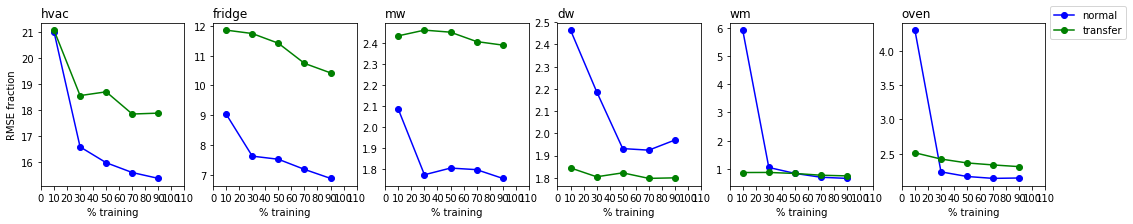

In [154]:
mean_t = pd.Panel(err_t).mean(axis=0)
mean_n = pd.Panel(err_n).mean(axis=0)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'gd'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
#     df1 = mean_out['normal']['feature'][appliance]
#     df2 = mean_out['normal']['None'][appliance]
#     df3 = mean_out['transfer']['feature'][appliance]
#     df4 = mean_out['transfer']['None'][appliance]
#     df = pd.concat([df1, df2, df3, df4], axis = 1)
    df1 = mean_n[appliance]
    df2 = mean_t[appliance]
    df = pd.concat([df1, df2], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal",'transfer'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/08/featurefactorization_all.pdf", bbox_inches="tight", dpi=300, format='pdf')

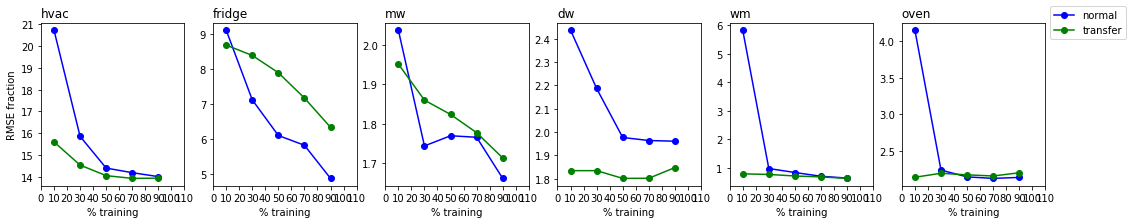

In [157]:
mean_t = pd.Panel(err_t).mean(axis=0)
mean_n = pd.Panel(err_n).mean(axis=0)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
algo = 'gd'

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
#     df1 = mean_out['normal']['feature'][appliance]
#     df2 = mean_out['normal']['None'][appliance]
#     df3 = mean_out['transfer']['feature'][appliance]
#     df4 = mean_out['transfer']['None'][appliance]
#     df = pd.concat([df1, df2, df3, df4], axis = 1)
    df1 = mean_n[appliance]
    df2 = mean_t[appliance]
    df = pd.concat([df1, df2], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle(algo, fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal",'transfer'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/08/featurefactorization_all.pdf", bbox_inches="tight", dpi=300, format='pdf')